In [ ]:
# Import packages and check versions

import os
import pandas as pd
import pandas_ta
import numpy
import vnquant  # try restarting (Runtime > Restart Runtime) the kernel (runtime) if vnquant is not properly working (i.e cannot import or cannot use module normally)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

print(
    '===== Package version =====',
    f'Pandas: {pd.__version__}',
    f'Pandas_ta: {pandas_ta.__version__}',
    f'Numpy: {numpy.__version__}',
    f'Vnquant: {vnquant.__version__}',
    f'Matplotlib: {matplotlib.__version__}',
    f'Seaborn: {sns.__version__}',
    f'Scikit-learn: {sklearn.__version__}',
    sep='\n'
)

===== Package version =====
Pandas: 2.0.3
Pandas_ta: 0.3.14b0
Numpy: 1.25.1
Vnquant: 0.1.1
Matplotlib: 3.7.2
Seaborn: 0.12.2
Scikit-learn: 1.3.0


In [ ]:
# Global constants
# Directories are relative to project's root

DATA_DIR = 'data'
DATA_RAW_DIR = 'data/raw'
PROCESSED_DATA_DIR = 'data/processed'
STOCK_INDEX_PARAM = 'FPT'

In [ ]:
def print_dataframe_details(df):
  print(df)
  # print(df.dtypes)
  # print(df.isna().any())
  df.info()
  print(df.describe())

In [ ]:
kaggle_df = pd.read_csv(f'{DATA_RAW_DIR}/kaggle/{STOCK_INDEX_PARAM}.csv') # load raw dataframe
kaggle_df.drop('<Ticker>', axis=1, inplace=True)  # drop unused column
kaggle_df.columns = kaggle_df.columns.str.replace('[<>]', '', regex=True) # standardize columns'name
kaggle_df.rename(columns={"DTYYYYMMDD": "Date"}, inplace=True, errors="raise")
kaggle_df['Date'] = pd.to_datetime(kaggle_df['Date'].astype(str), format='%Y%m%d')
kaggle_df = kaggle_df[['Date', 'Open', 'High', 'Low', 'Close']] # reorganize columns in order 'OHLC'
kaggle_df.sort_values(by=['Date'], inplace=True)
kaggle_df = kaggle_df.reset_index(drop=True)
print_dataframe_details(kaggle_df)

           Date     Open     High      Low    Close
0    2006-12-13  19.4343  19.4343  19.4343  19.4343
1    2006-12-14  20.4060  20.4060  20.4060  20.4060
2    2006-12-15  21.4263  21.4263  21.4263  21.4263
3    2006-12-18  22.4952  22.4952  22.4952  22.4952
4    2006-12-19  23.6127  23.6127  23.6127  23.6127
...         ...      ...      ...      ...      ...
3613 2021-06-21  85.6000  86.3000  83.2000  85.6000
3614 2021-06-22  86.1000  86.6000  85.4000  85.4000
3615 2021-06-23  85.3000  85.6000  84.1000  84.9000
3616 2021-06-24  84.3000  84.9000  83.9000  84.7000
3617 2021-06-25  84.7000  85.4000  84.2000  85.2000

[3618 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618 entries, 0 to 3617
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3618 non-null   datetime64[ns]
 1   Open    3618 non-null   float64       
 2   High    3618 non-null   float64       
 3   Low     3618 non-nul

In [ ]:
# source can be 'vnd' (vndirect) or 'cafe' (cafef)
# force_reload is True if we want to fetch data from api
def vnquant_load_raw_data(source, force_reload=False):
  VNQUANT_DATA_FOLDER = f'{DATA_RAW_DIR}/vnquant'
  STOCK_INDEX_DATA_CSV = f'{VNQUANT_DATA_FOLDER}/{STOCK_INDEX_PARAM}.csv'

  if os.path.exists(STOCK_INDEX_DATA_CSV) and not force_reload:
    return pd.read_csv(STOCK_INDEX_DATA_CSV)

  data_loader = vnquant.data.DataLoader(
      symbols=f'{STOCK_INDEX_PARAM}',
      start="2021-06-26",
      end="2022-12-31",
      minimal=True,
      data_source=source
  )
  os.makedirs(VNQUANT_DATA_FOLDER, exist_ok=True)
  data_loader.download().to_csv(STOCK_INDEX_DATA_CSV)

  return pd.read_csv(STOCK_INDEX_DATA_CSV)

In [ ]:
vnquant_df = vnquant_load_raw_data('vnd', True) # load raw dataframe
vnquant_df.drop(index=[0, 1], columns=['avg', 'volume'], inplace=True)  # drop unused columns
vnquant_df.rename(mapper=str.capitalize, axis='columns', inplace=True, errors="raise")  # capitalize columns' name
vnquant_df.rename(columns = {'Attributes':'Date'}, inplace=True, errors="raise")
vnquant_df = vnquant_df[['Date', 'Open', 'High', 'Low', 'Close']] # reorganize columns in order 'OHLC'
# vnquant_df['Date'] = vnquant_df['Date'].apply(lambda date_str: date_str.replace('-', '')).astype(int) # change type of column 'Date' to int64
vnquant_df['Date'] = pd.to_datetime(vnquant_df['Date']) # change type of column 'Date' to datetime64[ns]
vnquant_df.iloc[:, 1:] = vnquant_df.iloc[:, 1:].astype(float) # change type of columns O, H, L, C
vnquant_df.sort_values(by=['Date'], inplace=True)
vnquant_df = vnquant_df.reset_index(drop=True)
print_dataframe_details(vnquant_df)

2023-07-12 00:29:00,837 : INFO : data FPT from 2021-06-26 to 2022-12-31 have already cloned!


          Date  Open  High   Low Close
0   2021-06-28  86.1  86.1  85.4  85.7
1   2021-06-29  86.6  89.0  86.3  88.6
2   2021-06-30  89.0  89.1  88.0  88.0
3   2021-07-01  88.1  88.9  88.0  88.9
4   2021-07-02  89.3  92.5  88.9  91.9
..         ...   ...   ...   ...   ...
377 2022-12-26  77.7  78.1  76.4  76.4
378 2022-12-27  76.4  77.5  76.0  76.5
379 2022-12-28  77.0  77.0  76.0  76.7
380 2022-12-29  76.5  77.0  76.2  76.2
381 2022-12-30  76.2  76.9  76.0  76.9

[382 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    382 non-null    datetime64[ns]
 1   Open    382 non-null    object        
 2   High    382 non-null    object        
 3   Low     382 non-null    object        
 4   Close   382 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 15.1+ KB
                                Date

In [ ]:
training_set, test_set = kaggle_df.set_index('Date'), vnquant_df.set_index('Date')
print(training_set)
print(training_set.dtypes)
print(test_set)
print(test_set.dtypes)

               Open     High      Low    Close
Date                                          
2006-12-13  19.4343  19.4343  19.4343  19.4343
2006-12-14  20.4060  20.4060  20.4060  20.4060
2006-12-15  21.4263  21.4263  21.4263  21.4263
2006-12-18  22.4952  22.4952  22.4952  22.4952
2006-12-19  23.6127  23.6127  23.6127  23.6127
...             ...      ...      ...      ...
2021-06-21  85.6000  86.3000  83.2000  85.6000
2021-06-22  86.1000  86.6000  85.4000  85.4000
2021-06-23  85.3000  85.6000  84.1000  84.9000
2021-06-24  84.3000  84.9000  83.9000  84.7000
2021-06-25  84.7000  85.4000  84.2000  85.2000

[3618 rows x 4 columns]
Open     float64
High     float64
Low      float64
Close    float64
dtype: object
            Open  High   Low Close
Date                              
2021-06-28  86.1  86.1  85.4  85.7
2021-06-29  86.6  89.0  86.3  88.6
2021-06-30  89.0  89.1  88.0  88.0
2021-07-01  88.1  88.9  88.0  88.9
2021-07-02  89.3  92.5  88.9  91.9
...          ...   ...   ...   ...
20

In [ ]:
zero_value_index_as_str = training_set.loc[training_set['Open'] == 0].index.strftime('%Y-%m-%d').values[0]
print(training_set[training_set['Open'].index < zero_value_index_as_str]['Open'].mean())
training_set.loc[zero_value_index_as_str]['Open'] = training_set[training_set['Open'].index < zero_value_index_as_str]['Open'].mean()

22.291139999999995


In [ ]:
# As shown above, our training set has no null values
# We show some basic statistics of traning set
training_set.describe()

,Open,High,Low,Close
count,3618.000000,3618.000000,3618.000000,3618.000000
mean,19.696927,19.904324,19.503354,19.698241
std,13.954119,14.125951,13.808160,13.981423
min,3.476100,3.662200,3.476100,3.580300
25%,9.674125,9.769700,9.578525,9.659875
50%,15.901100,16.073250,15.724400,15.833100
75%,26.503700,26.749000,26.277600,26.497600
max,87.900000,88.500000,87.000000,87.100000


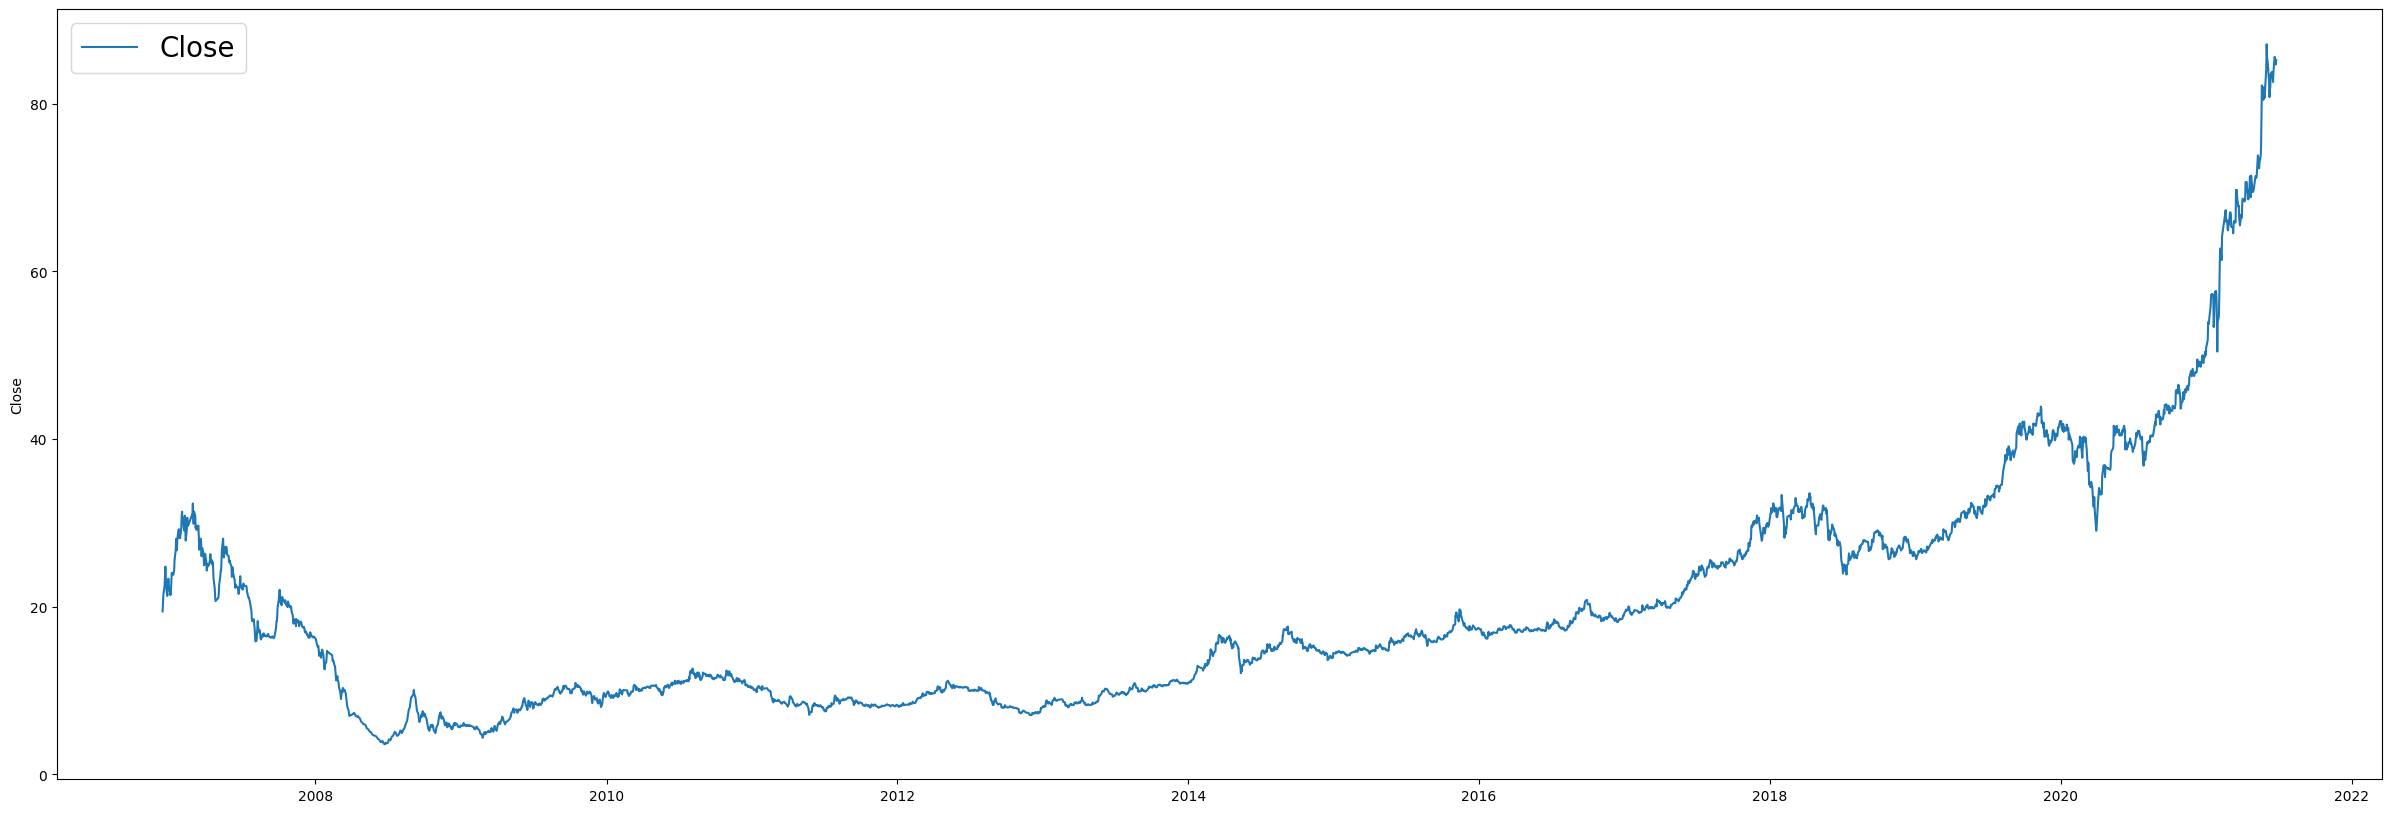

In [ ]:
plt.figure(figsize=(30, 10))
plt.ylabel('Close')
plt.plot(training_set['Close'])
plt.legend(['Close'], loc ="upper left", fontsize='20')
plt.show()

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


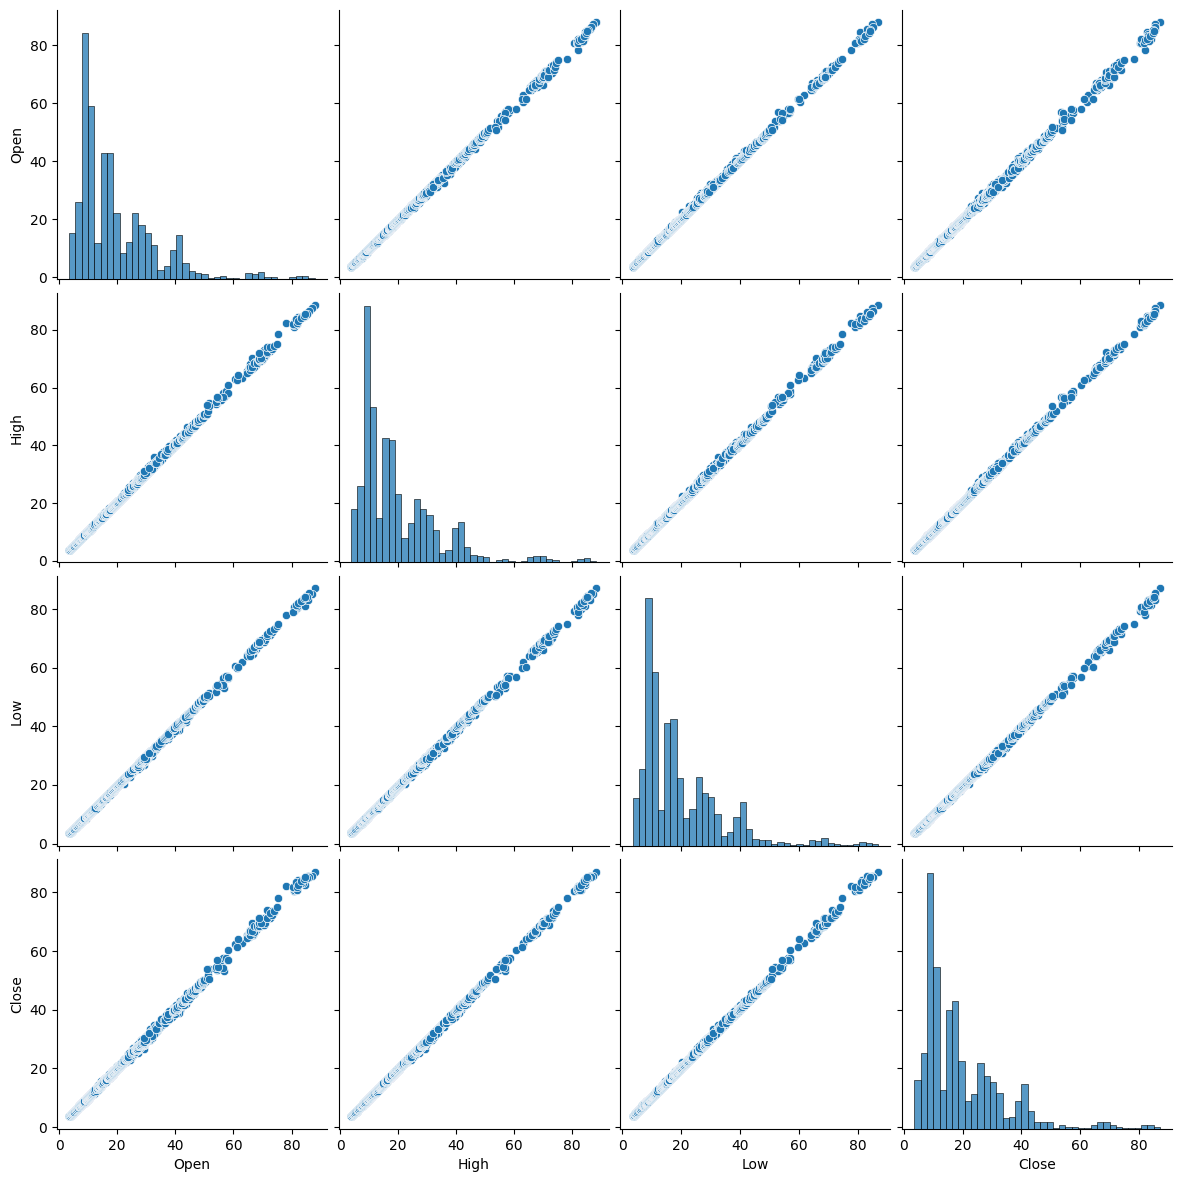

In [ ]:
sns.pairplot(training_set, height=3)

<Axes: >

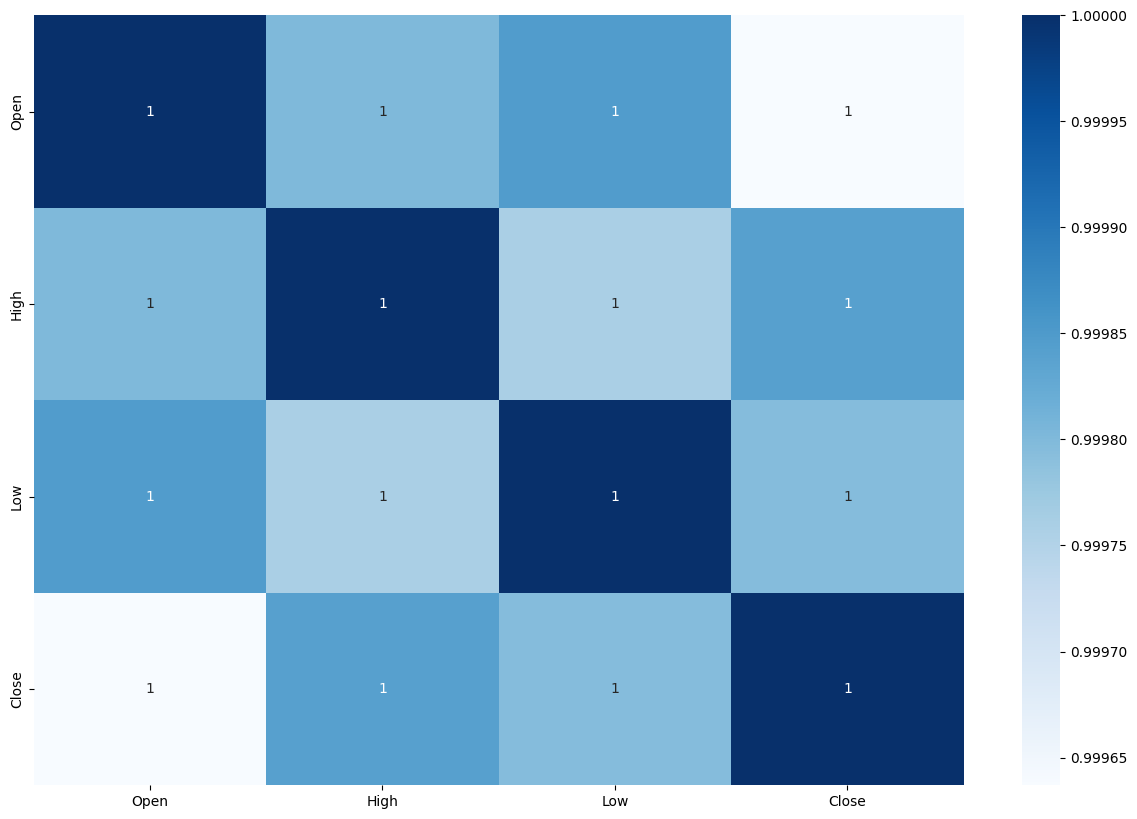

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(training_set.corr(), cmap='Blues', annot=True)

In [ ]:
# Add technical indicator EMA_10
training_set_processed = training_set.drop(['Open', 'High', 'Low'], axis=1)
training_set_processed.ta.ema(close='Close', length=10, append=True)
print(training_set_processed.head(20))

# Because EMA_10 is generated using results of 9 previous days, so the first 9 days in this dataset will have NaN values of EMA_10
training_set_processed.dropna(inplace=True)
print(training_set_processed.head(20))

              Close     EMA_10
Date                          
2006-12-13  19.4343        NaN
2006-12-14  20.4060        NaN
2006-12-15  21.4263        NaN
2006-12-18  22.4952        NaN
2006-12-19  23.6127        NaN
2006-12-20  24.7787        NaN
2006-12-21  23.5641        NaN
2006-12-22  22.3980        NaN
2006-12-25  21.2806        NaN
2006-12-26  22.3009  22.169680
2006-12-27  23.3212  22.379047
2006-12-28  23.3212  22.550348
2006-12-29  22.3494  22.513812
2007-01-02  21.3777  22.307246
2007-01-03  21.8636  22.226583
2007-01-04  22.9325  22.354932
2007-01-05  24.0499  22.663108
2007-01-08  23.8070  22.871088
2007-01-09  23.8070  23.041254
2007-01-10  24.0499  23.224644
              Close     EMA_10
Date                          
2006-12-26  22.3009  22.169680
2006-12-27  23.3212  22.379047
2006-12-28  23.3212  22.550348
2006-12-29  22.3494  22.513812
2007-01-02  21.3777  22.307246
2007-01-03  21.8636  22.226583
2007-01-04  22.9325  22.354932
2007-01-05  24.0499  22.663108
2007-01-

In [ ]:
# Add technical indicator EMA_10
test_set_processed = test_set.drop(['Open', 'High', 'Low'], axis=1)
test_set_processed.ta.ema(close='Close', length=10, append=True)
print(training_set_processed.head(20))

# Because EMA_10 is generated using results of 9 previous days, so the first 9 days in this dataset will have NaN values of EMA_10
test_set_processed.dropna(inplace=True)
print(test_set_processed.head(20))

              Close     EMA_10
Date                          
2006-12-26  22.3009  22.169680
2006-12-27  23.3212  22.379047
2006-12-28  23.3212  22.550348
2006-12-29  22.3494  22.513812
2007-01-02  21.3777  22.307246
2007-01-03  21.8636  22.226583
2007-01-04  22.9325  22.354932
2007-01-05  24.0499  22.663108
2007-01-08  23.8070  22.871088
2007-01-09  23.8070  23.041254
2007-01-10  24.0499  23.224644
2007-01-11  24.2929  23.418872
2007-01-12  25.5075  23.798623
2007-01-15  26.7707  24.339001
2007-01-16  28.0826  25.019655
2007-01-17  26.7222  25.329209
2007-01-18  26.7707  25.591298
2007-01-19  28.0826  26.044262
2007-01-22  29.1514  26.609196
2007-01-23  29.2486  27.089088
           Close     EMA_10
Date                       
2021-07-09  89.7  89.280000
2021-07-12  86.1  88.701818
2021-07-13  87.0  88.392397
2021-07-14  85.2  87.811961
2021-07-15  85.4  87.373423
2021-07-16  86.8  87.269164
2021-07-19  84.7  86.802043
2021-07-20  86.8  86.801672
2021-07-21  86.6  86.765004
2021-07-22

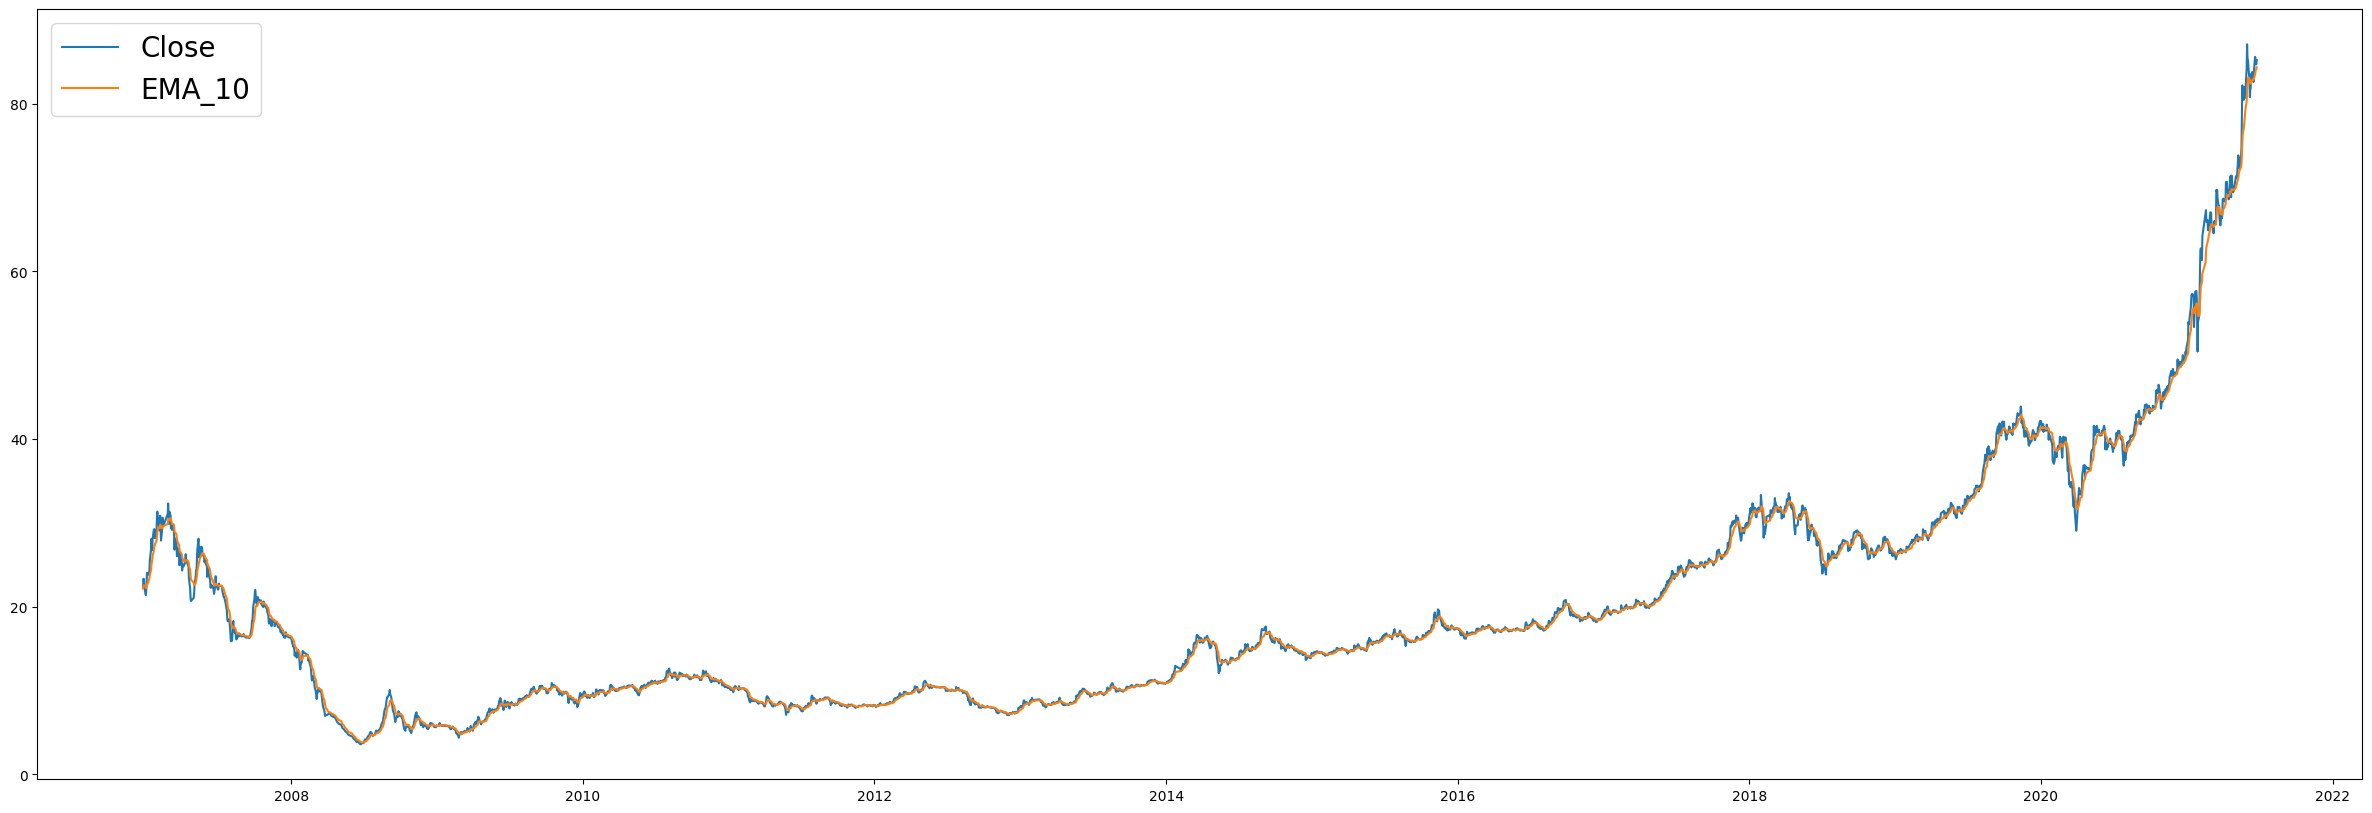

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(training_set_processed)
plt.legend(['Close', 'EMA_10'], loc ="upper left", fontsize='20')
plt.show()

In [ ]:
scaler = StandardScaler()
X_training, y_training = scaler.fit_transform(training_set_processed[['Close']]), training_set_processed['EMA_10']
X_test, y_test = scaler.transform(test_set_processed[['Close']]), test_set_processed['EMA_10']

print(X_training)

[[0.18639318]
 [0.25929183]
 [0.25929183]
 ...
 [4.6589893 ]
 [4.64469965]
 [4.68042377]]


In [ ]:
scaler = StandardScaler()
X_training, y_training = scaler.fit_transform(training_set[['Open']]), training_set['Close']
X_test, y_test = scaler.transform(test_set[['Open']]), test_set['Close']

In [ ]:
ols = LinearRegression()
ols.fit(X_training, y_training)
print('Coefficients:', ols.coef_, sep='\n')
print('Intercept:', ols.intercept_, sep='\n')

Coefficients:
[13.9744146]
Intercept:
19.698241072415698


In [ ]:
ridge = Ridge()
print('Ridge parameters:', ridge.get_params(), sep='\n')

Ridge parameters:
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


In [ ]:
ridge_hyperparams = {
    'alpha': numpy.arange(0.1, 10.1, 0.1).tolist()
}

ridge_search = GridSearchCV(
    ridge,
    ridge_hyperparams,
    cv=10
)

ridge_search.fit(X_training, y_training)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                                   0.7000000000000001, 0.8, 0.9, 1.0, 1.1,
                                   1.2000000000000002, 1.3000000000000003,
                                   1.4000000000000001, 1.5000000000000002, 1.6,
                                   1.7000000000000002, 1.8000000000000003,
                                   1.9000000000000001, 2.0, 2.1, 2.2,
                                   2.3000000000000003, 2.4000000000000004,
                                   2.5000000000000004, 2.6, 2.7,
                                   2.8000000000000003, 2.9000000000000004,
                                   3.0000000000000004, ...]})

In [ ]:
ridge = ridge_search.best_estimator_
ridge.get_params()

{'alpha': 1.9000000000000001,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [ ]:
lasso = Lasso()
print('Lasso parameters:', lasso.get_params(), sep='\n')

Lasso parameters:
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [ ]:
lasso_hyperparams = {
    'alpha': numpy.arange(0.1, 10.1, 0.1).tolist()
}

lasso_search = GridSearchCV(
    lasso,
    lasso_hyperparams,
    cv=10
)

lasso_search.fit(X_training, y_training)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                                   0.7000000000000001, 0.8, 0.9, 1.0, 1.1,
                                   1.2000000000000002, 1.3000000000000003,
                                   1.4000000000000001, 1.5000000000000002, 1.6,
                                   1.7000000000000002, 1.8000000000000003,
                                   1.9000000000000001, 2.0, 2.1, 2.2,
                                   2.3000000000000003, 2.4000000000000004,
                                   2.5000000000000004, 2.6, 2.7,
                                   2.8000000000000003, 2.9000000000000004,
                                   3.0000000000000004, ...]})

In [ ]:
lasso = lasso_search.best_estimator_
lasso.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [ ]:
rf = RandomForestRegressor()
params = {
    'bootstrap': True,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 1000,
}
rf.set_params(**params)
rf.get_params()

rf.fit(X_training, y_training)

RandomForestRegressor(n_estimators=1000)

In [ ]:
# rf = rf_randomized_search.best_estimator_
# rf.get_params()

In [ ]:
def validate_date_str(date_str):
  try:
    datetime.datetime.strptime(date_str, '%Y-%m-%d')
  except ValueError:
    raise ValueError("Incorrect data format, should be YYYY-MM-DD")

def get_estimator_scores(estimator, y_truth, X):
  return {
      'MAE': mean_absolute_error(y_truth, estimator.predict(X)),
      'MSE': mean_squared_error(y_truth, estimator.predict(X)),
      'R-squared': r2_score(y_truth, estimator.predict(X))
  }

def plot_prediction(estimator, date_index, X, y_truth, plot_type='mix', lower_bound=None, upper_bound=None, plot_title=None):
  y_truth_ndarray = y_truth.values
  y_pred_ndarray = estimator.predict(X)

  if type(lower_bound) != type(upper_bound):
    raise Exception('Lower and upper bound must share the same data type.')

  if lower_bound and upper_bound:
    if isinstance(lower_bound, str) and isinstance(upper_bound, str):
      validate_date_str(lower_bound)
      validate_date_str(upper_bound)
      lower_bound = date_index.get_loc(lower_bound)
      upper_bound = date_index.get_loc(upper_bound)

    date_index = date_index[lower_bound:upper_bound]
    y_truth_ndarray = y_truth_ndarray[lower_bound:upper_bound]
    y_pred_ndarray = y_pred_ndarray[lower_bound:upper_bound]

  plt.figure(figsize=(30, 10))
  if plot_title:
    plt.title(plot_title, fontsize=20)

  if plot_type == 'mix':
    plt.plot(date_index, y_truth_ndarray, '-r', date_index, y_pred_ndarray, 'xb')
  if plot_type == 'scatter':
    plt.scatter(x=date_index, y=y_truth_ndarray, color='red')
    plt.scatter(x=date_index, y=y_pred_ndarray, color='blue')

  plt.legend(['Ground Truth', 'Predicted Value'], loc ="upper left", fontsize='20')
  plt.show()

In [ ]:
models_scores_on_training_set = pd.DataFrame(
    data=[
        get_estimator_scores(ols, y_training, X_training),
        get_estimator_scores(ridge, y_training, X_training),
        get_estimator_scores(lasso, y_training, X_training),
        get_estimator_scores(rf, y_training, X_training)
    ],
    index=['OLS', 'Ridge', 'Lasso', 'Random Forest']
)
models_scores_on_training_set.style.set_caption('Models \'s Scores On Training Set').set_table_styles([
    dict(selector='caption', props=[('font-size', '120%'), ('font-weight', 'bold'), ('margin-bottom', '20px')])
])

,MAE,MSE,R-squared
OLS,0.212794,0.141883,0.999274
Ridge,0.211973,0.141937,0.999274
Lasso,0.226426,0.151883,0.999223
Random Forest,0.139553,0.052079,0.999734


In [ ]:
models_scores_on_test_set = pd.DataFrame(
    data=[
        get_estimator_scores(ols, y_test, X_test),
        get_estimator_scores(ridge, y_test, X_test),
        get_estimator_scores(lasso, y_test, X_test),
        get_estimator_scores(rf, y_test, X_test)
    ],
    index=['OLS', 'Ridge', 'Lasso', 'Random Forest']
)
models_scores_on_test_set.style.set_caption('Models \'s Scores On Test Set').set_table_styles([
    dict(selector='caption', props=[('font-size', '120%'), ('font-weight', 'bold'), ('margin-bottom', '20px')])
])

,MAE,MSE,R-squared
OLS,1.195088,3.024062,0.970616
Ridge,1.189565,3.013523,0.970718
Lasso,1.219289,3.123547,0.969649
Random Forest,6.894367,93.662823,0.089900


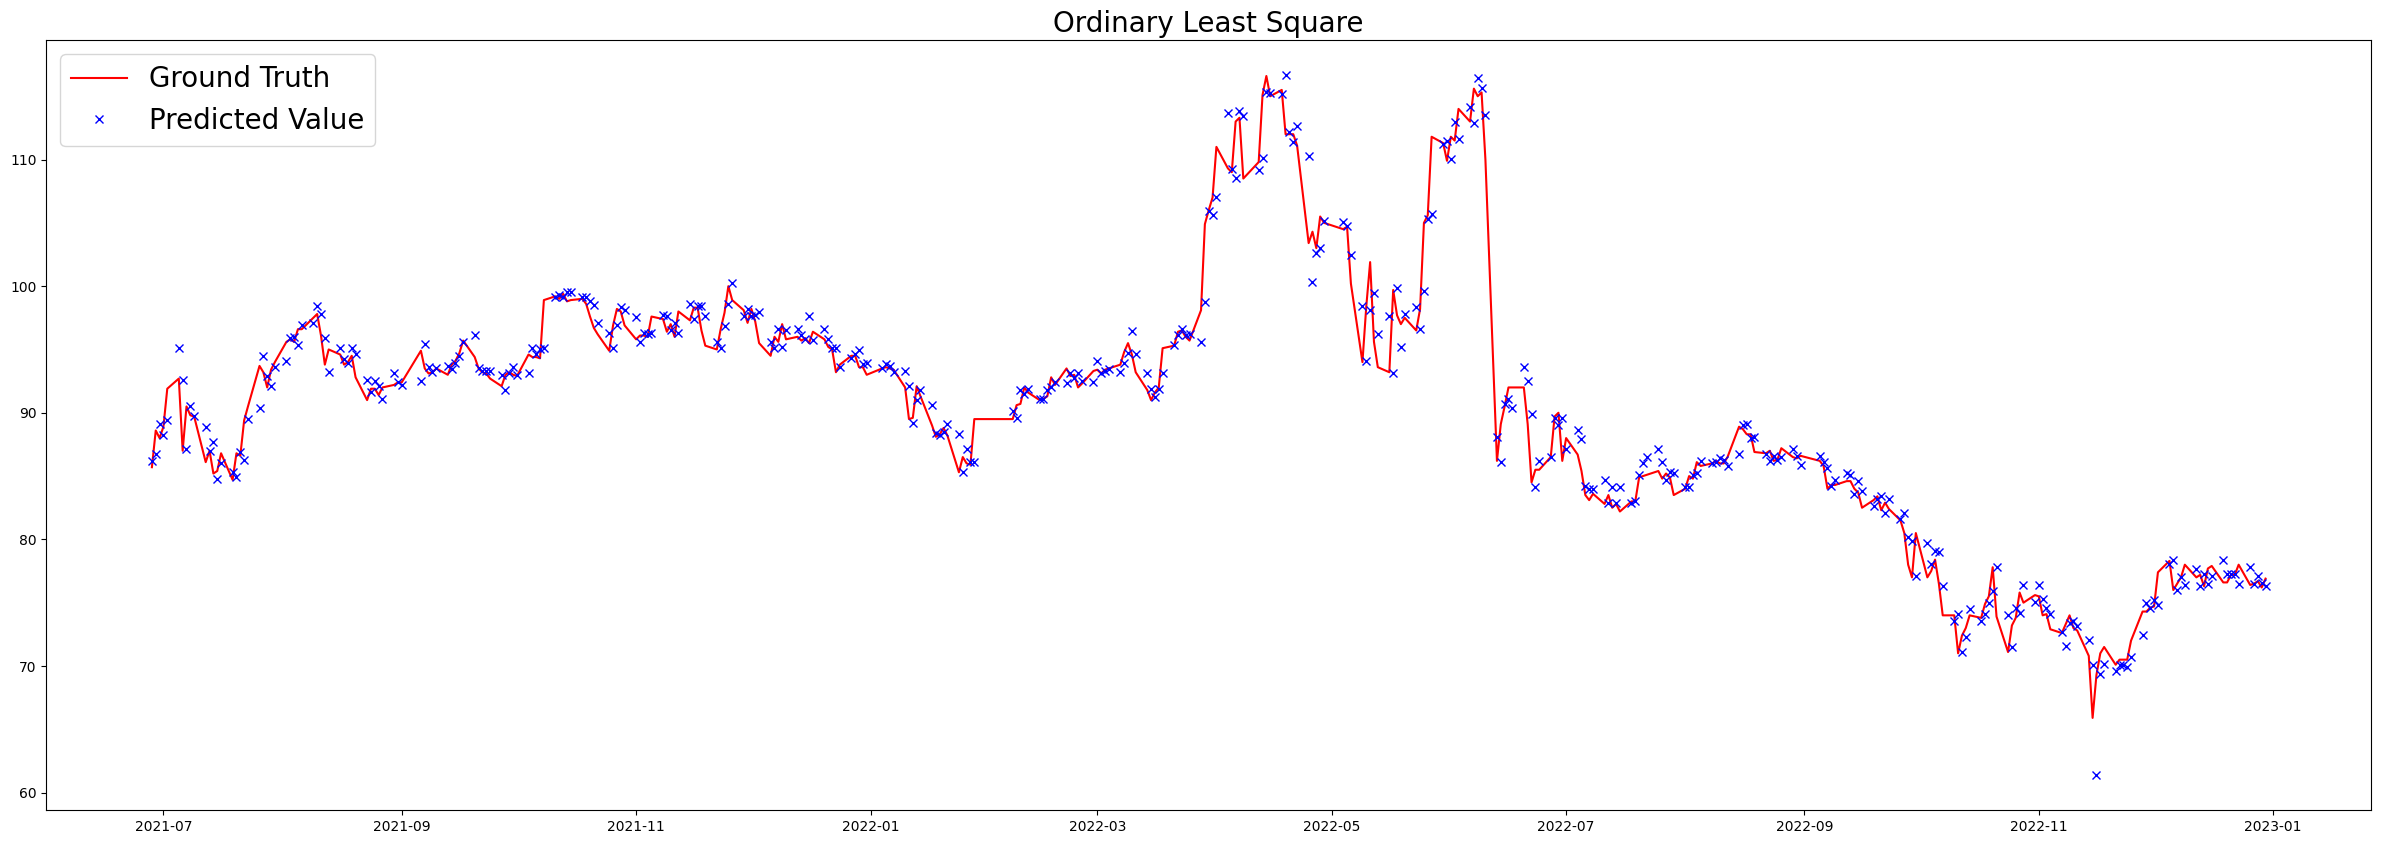

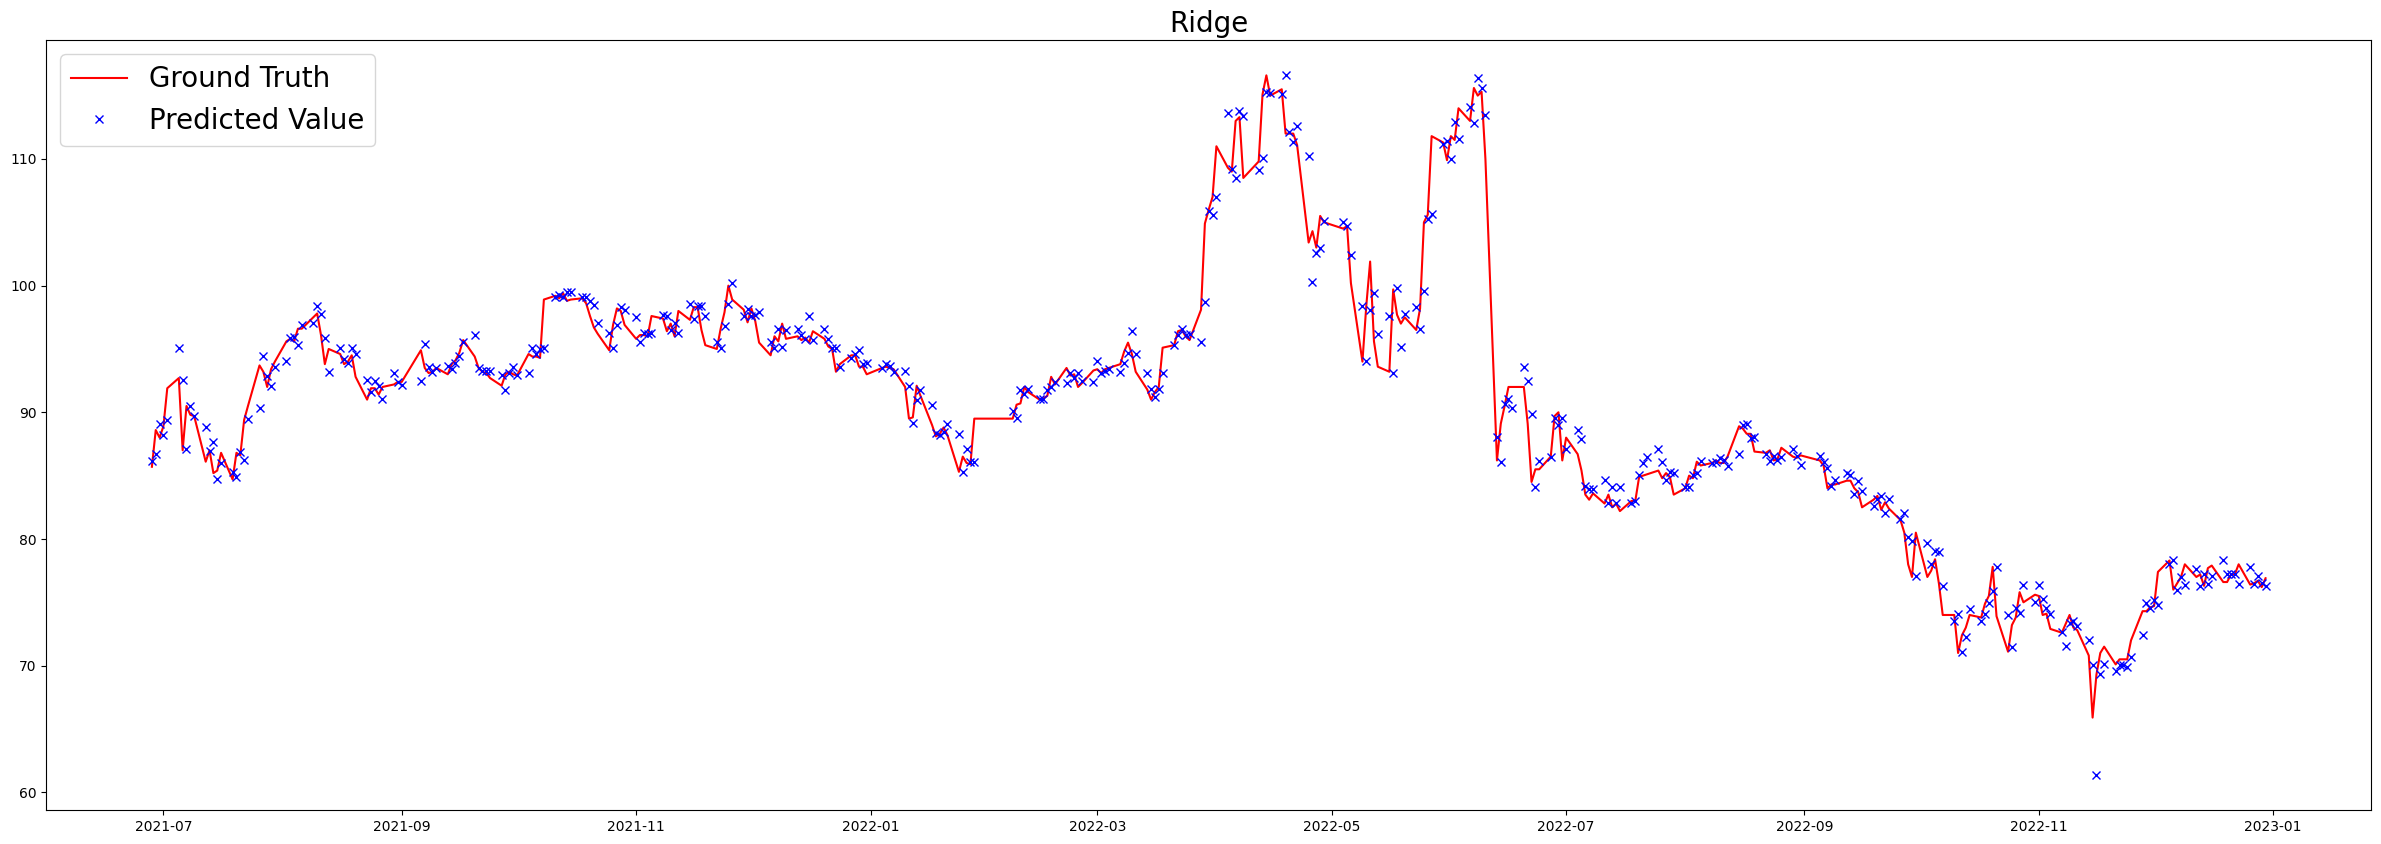

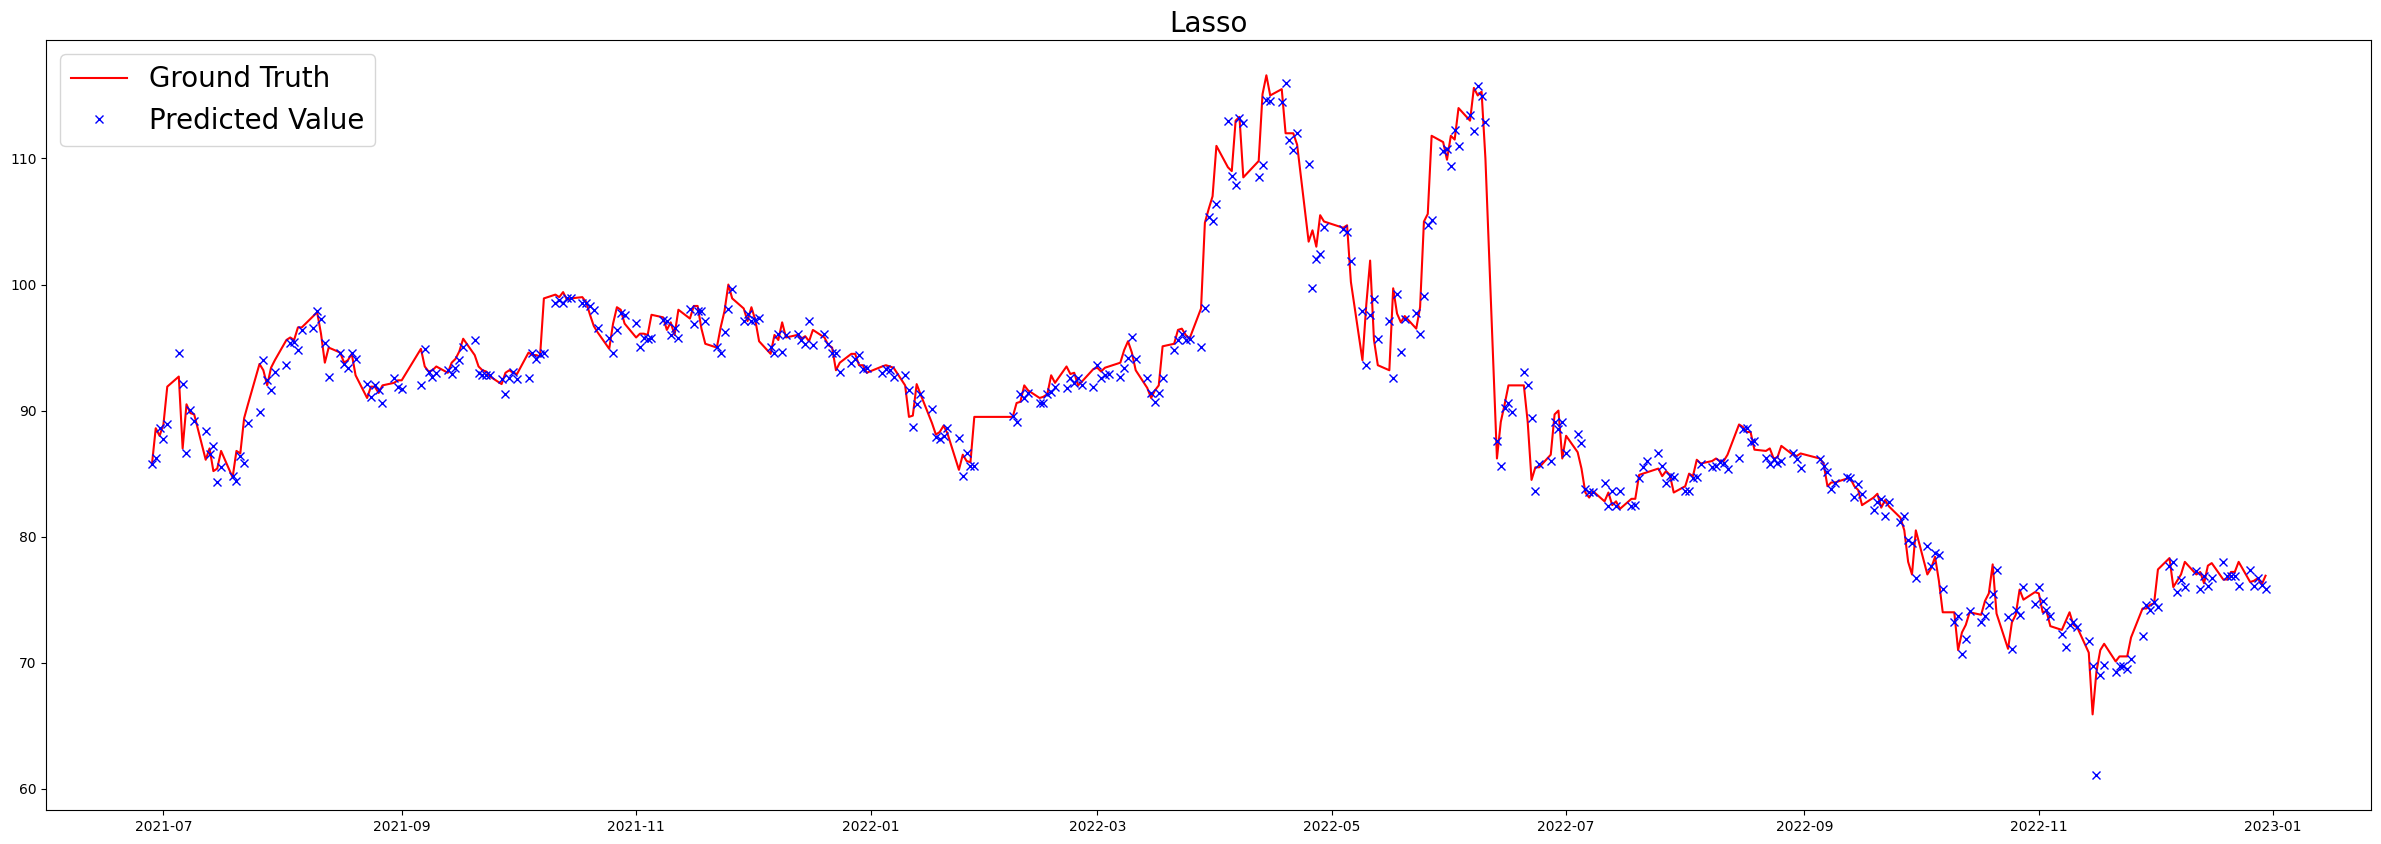

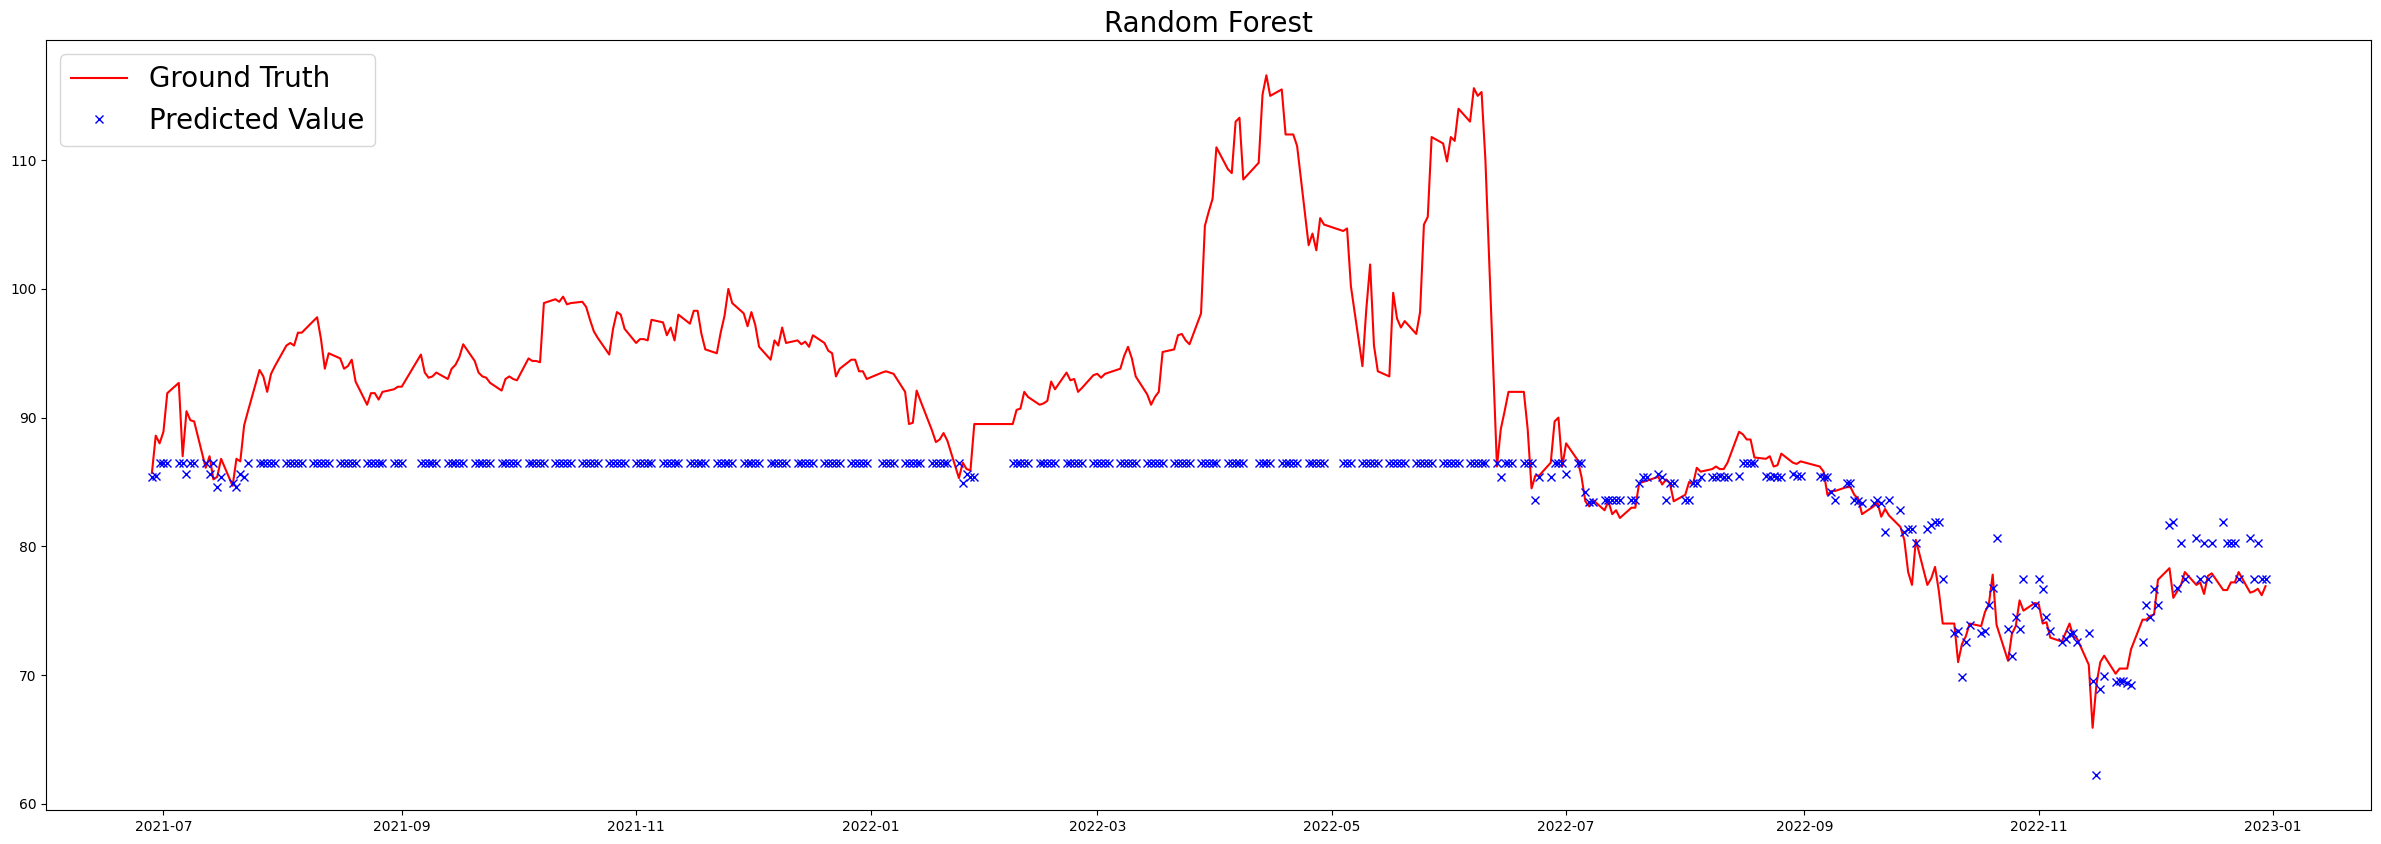

In [ ]:
plot_prediction(ols, test_set.index, X_test, y_test, plot_title='Ordinary Least Square')
plot_prediction(ridge, test_set.index, X_test, y_test, plot_title='Ridge')
plot_prediction(lasso, test_set.index, X_test, y_test, plot_title='Lasso')
plot_prediction(rf, test_set.index, X_test, y_test, plot_title='Random Forest')